In [18]:
pip install keras_preprocessing


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import shutil
TRAINING_DIR = "Train"

training_datagen = ImageDataGenerator(rescale=1./255,
                                    zoom_range=0.15,
                                    horizontal_flip=True,
                                   fill_mode='nearest')

VALIDATION_DIR = "Test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	shuffle = True,
	class_mode='categorical',
  batch_size = 128
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
	shuffle = True,
  batch_size= 14
)

Found 2700 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import f1_score, precision_score
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<=0.1099 and logs.get('loss')<=0.1099):
      print('\n\n Reached The Destination!')
      self.model.stop_training = True

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(validation_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = validation_generator.classes
        f1 = f1_score(y_true, y_pred_classes, average='weighted')
        logs['val_f1'] = f1

class PrecisionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(validation_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = validation_generator.classes
        precision = precision_score(y_true, y_pred_classes, average='weighted')
        logs['val_precision'] = precision

# Compile your model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# Create a list of callbacks
callbacks = [
    myCallback(),
    F1ScoreCallback(),
    PrecisionCallback()
]

# Train your model
history = model.fit(
    train_generator,
    steps_per_epoch=14,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=14,
    callbacks=callbacks
)


print(len(base_model.layers))

c:\ProgramData\miniconda3\envs\tensor\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
14/14 [==============================] - 21s 1s/step - loss: 1.1686 - acc: 0.3477 - val_loss: 1.1197 - val_acc: 0.3469
Epoch 2/20
14/14 [==============================] - 16s 1s/step - loss: 1.1032 - acc: 0.3750 - val_loss: 1.0222 - val_acc: 0.4745
Epoch 3/20
14/14 [==============================] - 18s 1s/step - loss: 1.0658 - acc: 0.4206 - val_loss: 0.9768 - val_acc: 0.5357
Epoch 4/20
14/14 [==============================] - 18s 1s/step - loss: 1.0347 - acc: 0.4624 - val_loss: 0.9542 - val_acc: 0.6071
Epoch 5/20
14/14 [==============================] - 18s 1s/step - loss: 1.0035 - acc: 0.5143 - val_loss: 0.9248 - val_acc: 0.6582
Epoch 6/20
14/14 [==============================] - 20s 1s/step - loss: 0.9776 - acc: 0.5564 - val_loss: 0.9126 - val_acc: 0.6684
Epoch 7/20
14/14 [==============================] - 17s 1s/step - loss: 0.9611 - acc: 0.5734 - val_loss: 0.8751 - val_acc: 0.6939
Epoch 8/20
14/14 [==============================] - 19s 1s/step - loss: 0.9556 - acc: 0.57

Final Training Accuracy: 0.7900
Final Validation Accuracy: 0.8265
Final Training Loss: 0.6872
Final Validation Loss: 0.6727
Final Training F1 Score: 0.3168
Final Validation F1 Score: 0.3168
Final Training Precision: 0.3544
Final Validation Precision: 0.3544


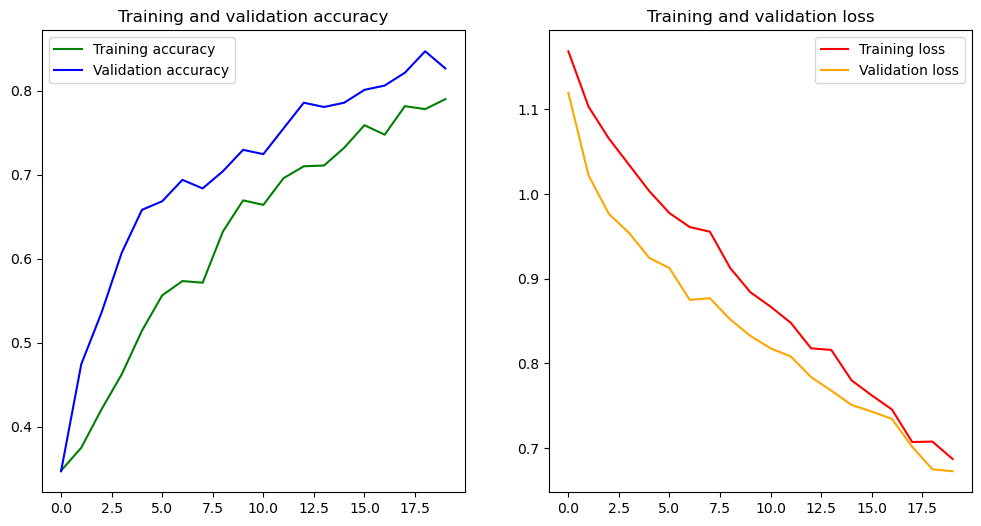

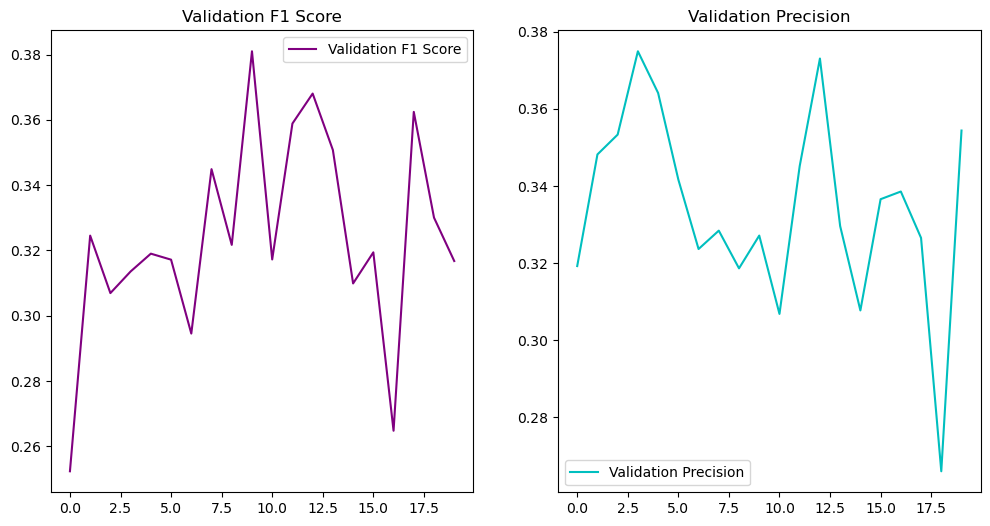

In [23]:


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score

# Extract the metrics
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['val_f1']  
precision = history.history['val_precision']  
# Get the number of epochs
epochs = range(len(acc))

# Print the final metrics
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]
final_train_f1 = f1[-1]
final_val_f1 = f1[-1]
final_train_precision = precision[-1]
final_val_precision = precision[-1]

print(f'Final Training Accuracy: {final_train_acc:.4f}')
print(f'Final Validation Accuracy: {final_val_acc:.4f}')
print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Training F1 Score: {final_train_f1:.4f}')
print(f'Final Validation F1 Score: {final_val_f1:.4f}')
print(f'Final Training Precision: {final_train_precision:.4f}')
print(f'Final Validation Precision: {final_val_precision:.4f}')

# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

plt.show()

# F1 Score and Precision Plot
plt.figure(figsize=(12, 6))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, f1, 'purple', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.legend(loc='best')

# Precision Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, precision, 'c', label='Validation Precision')
plt.title('Validation Precision')
plt.legend(loc='best')

plt.show()



In [24]:

model.save('model.h5')

In [30]:
#predicting any random image
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from keras.models import load_model

file_path="Test\\Smoke\image_98.jpg"
uploaded = Image.open(file_path)
model=load_model('model.h5')
img=image.load_img(file_path, target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)/255.0
classes=model.predict(x)

if(np.argmax(classes[0])==0):
    print("Fire Detected")
    print(np.argmax(classes[0])==0, max(classes[0]))
elif(np.argmax(classes[0])==2):
    print("Smoke Detected")
    print(np.argmax(classes[0])==2, max(classes[0]))
else:
    print("No Fire or Smoke Detected")
    print(np.argmax(classes[0])==1, max(classes[0]))

Smoke Detected
True 0.42186972


In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.utils import np_utils
import cv2

model = tf.keras.models.load_model("model.h5")
video = cv2.VideoCapture(0)

while True:
    ret, frame = video.read()
    
    # Check if frame is None
    if frame is None:
        print("Error: Failed to read frame from video capture.")
        break
    
    im = Image.fromarray(frame, 'RGB')
    im = im.resize((224, 224))
    img_array = np.array(im)
    img_array = np.expand_dims(img_array, axis=0) / 255

    # Use the model to predict the probability of each class (fire or no fire)
    classes = model.predict(img_array)

    if np.argmax(classes[0]) == 0:
        cv2.putText(frame, "Fire Detected", (18, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    elif np.argmax(classes[0]) == 2:
        cv2.putText(frame, "Smoke Detected", (18, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    else:
        cv2.putText(frame, "No Fire or Smoke Detected", (18, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the video frame in a window
    cv2.imshow("Fire and Smoke Detection", frame)

    # Exit the loop if the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
video.release()
cv2.destroyAllWindows()

Error: Failed to read frame from video capture.
